<a href="https://colab.research.google.com/github/ArashDehghanyan/ml-and-vision-practices/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries


In [2]:
import imageio
import tensorflow_probability as tfp
import numpy as np
import glob
import PIL
import matplotlib.pyplot as plt
import time
import tensorflow as tf

from IPython import display

#Download dataset

In [3]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


#Preprocess with Bernouli distribution

In [4]:
def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

print("N train examples:", train_images.shape[0])
print("N test examples:", test_images.shape[0])

N train examples: 60000
N test examples: 10000


In [5]:
train_size = train_images.shape[0]
test_size = test_images.shape[0]
batch_size  =32

In [6]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size))

In [7]:
print(len(train_dataset))
print(len(test_dataset))

1875
313


In [8]:
class CVAE(tf.keras.models.Model):
    """Convolutional Variational AutoEncoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.models.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, activation='relu'),
                tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, activation='relu'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(latent_dim + latent_dim)
            ]
        )

        self.decoder = tf.keras.models.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
                tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same')
            ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(mean.shape)
        return eps * tf.exp(logvar * .5) + mean

In [9]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), 
        axis=raxis
    )

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logits = model.decode(z)
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_logits)
    logpx_z = -tf.reduce_sum(cross_entropy, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
    """Executes one training step and returns the loss.

        This function computes the loss and gradients, and uses the latter to
        update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    

#Training

In [10]:
epochs = 10
# Set the dimensionality of the latent space to a plane for visualization use
latent_dim = 2

num_examples_to_generate = 16

random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim]
)

model = CVAE(latent_dim)

In [11]:
model.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 13, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 4)                 9220      
                                                                 
Total params: 28,036
Trainable params: 28,036
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1568)              4704      
                                                                 
 reshape (Reshape)           (None, 7, 7, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       18496     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289       
 ranspose)                                                       
                                                      

In [13]:
def generate_and_save_images(model, epoch, sample_test):
    mean, logvar = model.encode(sample_test)
    z = model.reparameterize(mean, logvar)
    probabilities = model.sample(z)
    plt.figure(figsize=(4, 4))
    for i in range(probabilities.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(probabilities[i, :, :, 0], cmap='gray')
        plt.axis('off')
    
    plt.savefig("image_at_epoch_{:04d}.png".format(epoch))
    plt.show()

In [14]:
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]
    

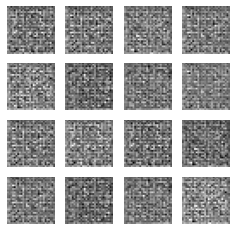

In [15]:
generate_and_save_images(model, 0, test_sample)

Epoch: 10, Test set ELBO: -155.84144592285156, Current elapsed time: 96.81196665763855


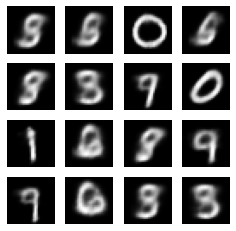

In [16]:
for epoch in range(1, epochs + 1):
    start = time.time()
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)
    end = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print("Epoch: {}, Test set ELBO: {}, Current elapsed time: {}".format(epoch, elbo, end - start))
    generate_and_save_images(model, epoch, test_sample)

#Generate an image from last training epoch

(-0.5, 287.5, 287.5, -0.5)

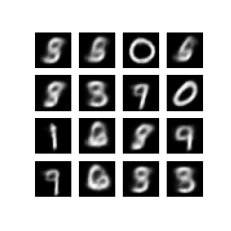

In [17]:
def display_image(epoch_no):
    return PIL.Image.open("image_at_epoch_{:04d}.png".format(epoch_no))

plt.imshow(display_image(epoch))
plt.axis('off')

#Display an animated GIF of all saved images

In [20]:
animated_file = "cvae.gif"

with imageio.get_writer(animated_file, mode='I') as writer:
    filenames = glob.glob("image*.png")
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


In [21]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-h0r76k96
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-h0r76k96
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=179891 sha256=1989d65d3e7c9b97bcedb7733d33099a2cad242516da8c1437eb8ba81e0c316b
  Stored in directory: /tmp/pip-ephem-wheel-cache-cq0nt7a9/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs



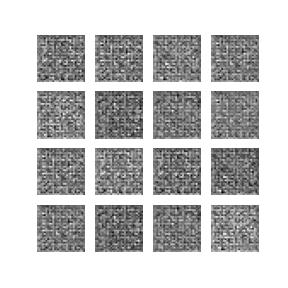

In [22]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(animated_file)

#Display a 2D manifold of digits from the latent space

In [25]:
def plot_latent_images(model, n, digit_size=28):
    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size * n
    image_height = image_width
    image = np.zeros((image_width, image_height))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            decoded = model.sample(z)
            digit = tf.reshape(decoded[0], (digit_size, digit_size))
            image[i*digit_size : (i+1)*digit_size, j*digit_size : (j+1)*digit_size] = digit.numpy()
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('off')
    plt.show()

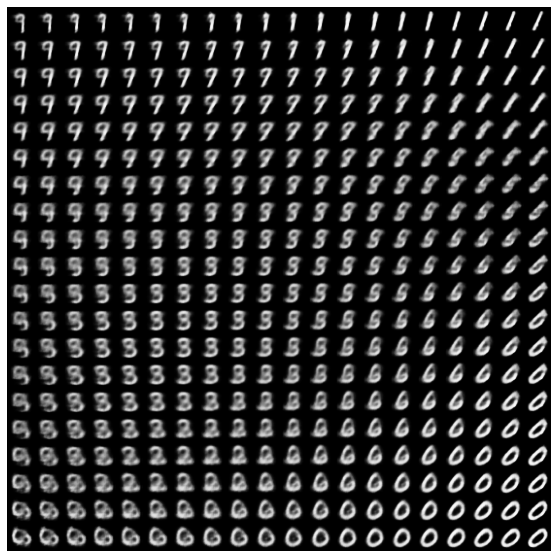

In [26]:
plot_latent_images(model, 20)